<a href="https://colab.research.google.com/github/mariabda2/ML_2022/blob/main/clases/clase_08_complejidad_modelos_sobreajuste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='black'>Complejidad de modelos </font>**

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/mariabda2/ML_2022/main/init.py
import init; init.init(force_download=False); 

replicating local resources


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

**Frontera de clasificación usando una función discriminante Guasiana**
<br> Utilizando la variante de análisis discriminante cuadrático (diferente matriz de cov para cada clase)

<br> N: número de muestras. n: 10 número de entrenamiento.

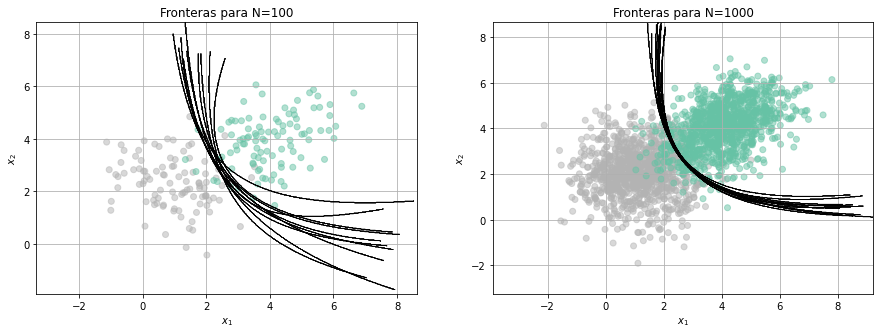

In [5]:
from local.lib.regularization import Fronteras
clf = QuadraticDiscriminantAnalysis()
Fronteras(clf,100,10) #Fronteras (modelo,N,n)

**Modelo de ventana de Parzen**

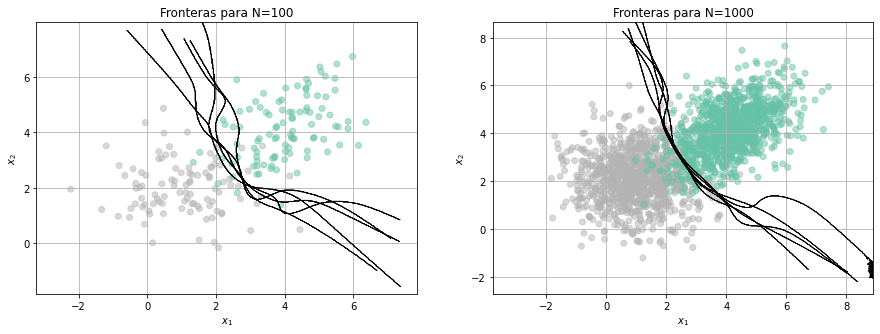

In [6]:
from local.lib.regularization import Kernel_classifier
clf = Kernel_classifier(bandwidth=0.5)
Fronteras(clf,100,5)

**Criterios para seleccionar modelos según su complejidad:**
- Akaike Information Criterion
- Bayesian Information Criterion
- Minimum Description Length



## **Bias vs Variance**
- **Bias (sesgo)**: es la diferencia entre la predicción promedio de nuestro modelo y el valor correcto que se pretende predecir. Un modelo con alto bias no captura las relaciones relevantes entre las características de entrada y las variables objetivo de salida, pone poca atención a los datos de entrenamiento y sobre-simplifica el modelo.

- **Variance**: es un error debido a una alta sensibilidad a pequeñas fluctuaciones en el conjunto de entrenamiento. Una varianza alta puede causar que el modelo se centre en el ruido contenido en los datos más que en la salida deseada. Los modelos que cometen error por varianza suelten tener buenas desempeños en entrenamiento pero altas tasasa de error en conjuntos de prueba.

Formalmente:

El sistema que queremos modelar está dado por:

$$y=f({\bf{x}}) + e$$

donde $e$ es el término de error el cual se asume distribuido normalmente con media 0.

$$Err({\bf{x}}) = E\left[ \left(y - \hat{f}({\bf{x}})\right)^2 \right]$$

Usando propiedades del valor esperado:

$$Err({\bf{x}}) = \left( E[\hat{f}({\bf{x}})] - f({\bf{x}})\right)^2 + E\left[\left(\hat{f}({\bf{x}}) - E\left[\hat{f}({\bf{x}})\right]\right)^2\right] + \sigma_e^2$$

$$Err({\bf{x}}) = \text{Bias}^2 + \text{Variance} + \text{Irreductible Error}$$

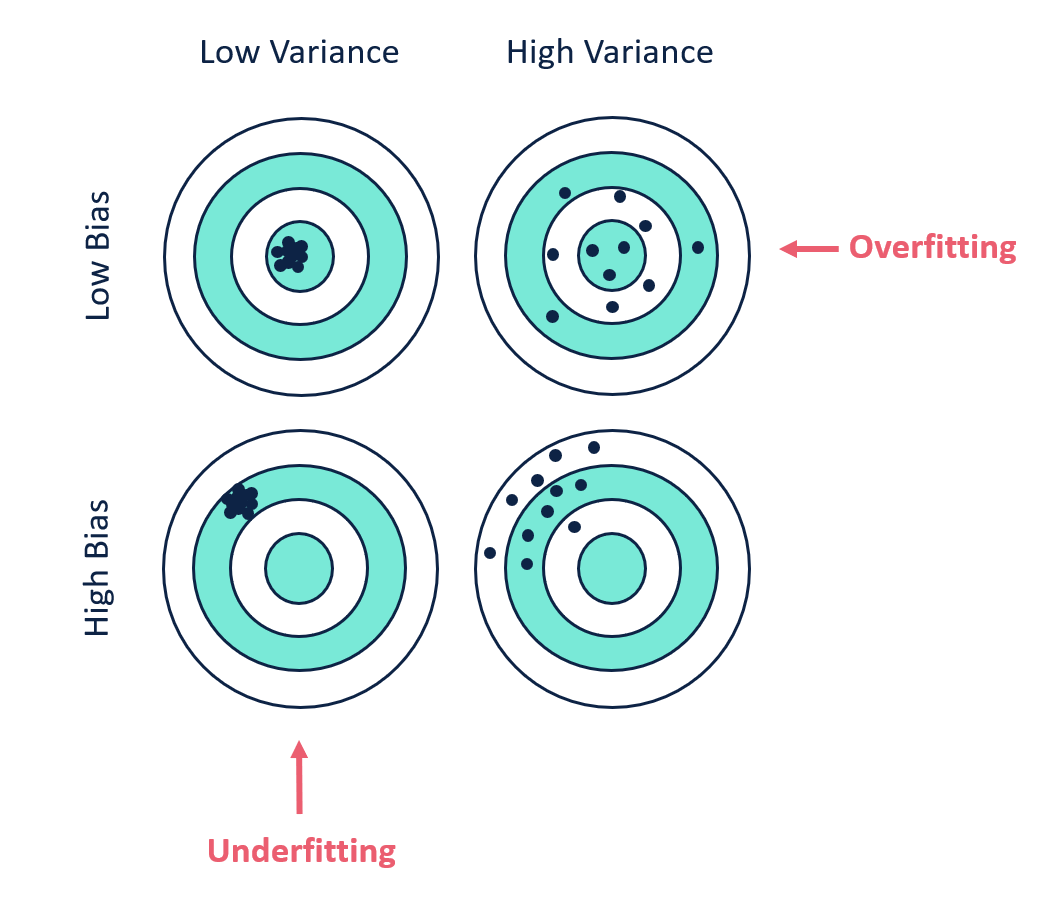

In [7]:
from IPython.display import Image
Image("local/imgs/biasVVariance.png", width = 600)

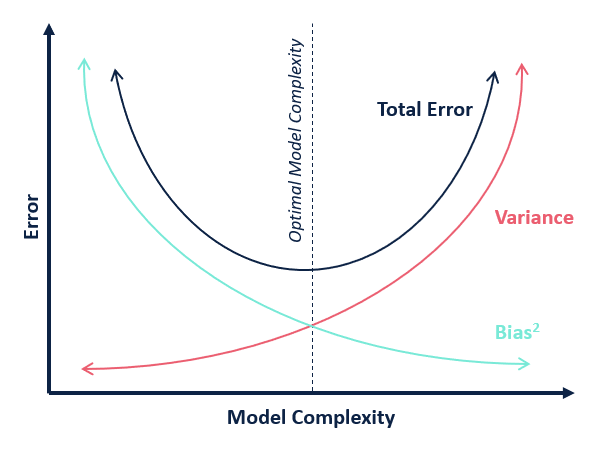

In [8]:
Image("local/imgs/tradeoff.png", width = 600)

**Ejemplo**

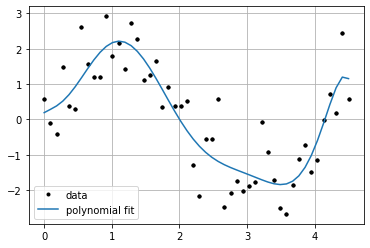

In [22]:
from local.lib.regularization import PolynomialLinearRegression
def f(size):
    '''
    Returns a sample with 'size' instances without noise.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5)
    return (x,y)

def sample(size):
    '''
    Returns a sample with 'size' instances.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5) + np.random.randn(x.size)
    return (x,y)
    
size = 50
f_x,f_y = f(size)
#plt.plot(f_x, f_y)
x, y = sample(50)
plt.plot(x, y, 'k.')
model = PolynomialLinearRegression(degree=8)
model.fit(x,y)
p_y = model.predict(x)
#plt.plot(f_x, f_y, label="true function")
plt.plot(x, y, 'k.', label="data")
plt.plot(x, p_y, label="polynomial fit")
plt.legend();
plt.grid();

...Ajustando el hiperparámetro del modelo: grado del polinomio

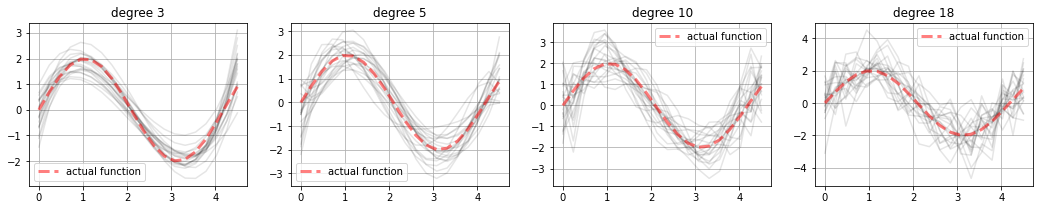

In [10]:
plt.figure(figsize=(18,3))
for k, degree in enumerate([3, 5, 10, 18]):
    plt.subplot(1,4,k+1)
    n_samples = 20
    n_models = 20
    avg_y = np.zeros(n_samples)
    for i in range(n_models):
        (x,y) = sample(n_samples)
        model = PolynomialLinearRegression(degree=degree)
        model.fit(x,y)
        p_y = model.predict(x)
        avg_y = avg_y + p_y
        plt.plot(x, p_y, 'k-', alpha=.1)
    avg_y = avg_y / n_models
    plt.plot(x, f(len(x))[1], 'b--', color="red", lw="3", alpha=.5, label="actual function")
    plt.legend();
    plt.grid();
    plt.title("degree %d"%degree)

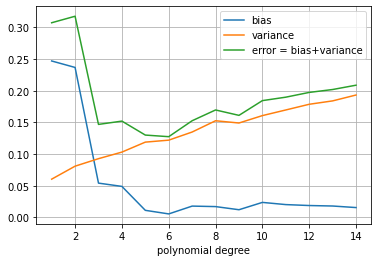

In [11]:
from numpy.linalg import norm
n_samples = 20
f_x, f_y = f(n_samples)
n_models = 100
max_degree = 15
var_vals =[]
bias_vals = []
error_vals = []
for degree in range(1, max_degree):
    avg_y = np.zeros(n_samples)
    models = []
    for i in range(n_models):
        (x,y) = sample(n_samples)
        model = PolynomialLinearRegression(degree=degree)
        model.fit(x,y)
        p_y = model.predict(x)
        avg_y = avg_y + p_y
        models.append(p_y)
    avg_y = avg_y / n_models
    bias_2 = norm(avg_y - f_y)/f_y.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += norm(avg_y - p_y)
    variance /= f_y.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)
plt.plot(range(1, max_degree), bias_vals, label='bias')
plt.plot(range(1, max_degree), var_vals, label='variance')
plt.plot(range(1, max_degree), error_vals, label='error = bias+variance')
plt.legend()
plt.xlabel("polynomial degree")
plt.grid();

-------------------

# <font color='blue'>Metodologías de validación</font>

Cuando vamos a resolver un problema de Machine Learning, tenemos un solo conjunto de datos $\mathcal{D} = \{({\bf{x}}_i,y_i)\}_{i=1}^N$. Las metodologías de validación nos permiten usar ese conjunto de manera apropiada para realizar la selección de los parámetros del modelo y estimar medidas de desempeño confiables.


Existen varias maneras de muestrear los datos, las dos metodologías más utilizadas son validación cruzada y Bootstrapping.

### **Validación cruzada ($k$-fold cross-validation)**

En primer lugar se divide el conjunto de datos de manera aleatoria en dos subconjuntos: Training y Test, típicamente 80% - 20% respectivamente. El conjunto de entrenamiento a su vez se divide nuevamente de manera aleatoria en $k$ subconjuntos disyuntos, se usan $k-1$ suubconjuntos para entrenar y el conjunto restante para validar; dicho proceso se repite $k$ veces. El proceso de entrenamiento y validación se utliza para seleccionar los hiperparámetros del modelo y el conjuto de test para evaluar el desempeño una vez escogido el mejor subconjunto de parámetros.

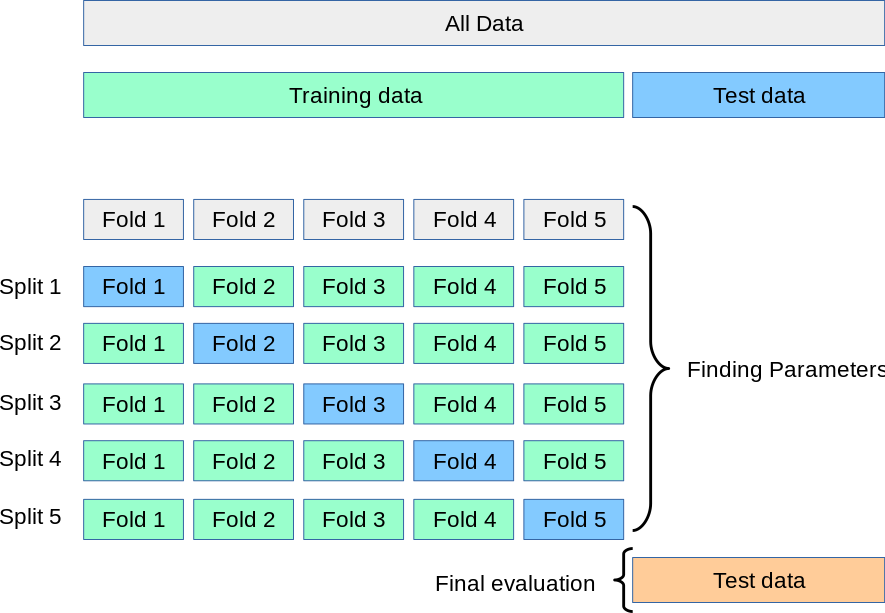

In [12]:
Image("local/imgs/grid_search_cross_validation.png", width = 600)

Imagen tomada de este [sitio](https://scikit-learn.org/stable/modules/cross_validation.html).

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def FronterasCV(X,Y, cv):
    nf = cv.get_n_splits(X)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Acc = np.zeros((4,nf))
    fold = 0
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
    for train_index, val_index in cv.split(X):
        fold += 1
        #------------------------------------
        Xtrain = X[train_index,:]
        Ytrain = Y[train_index]
        Xval = X[val_index,:]
        Yval = Y[val_index]
        #------------------------------------
        for i,n_neighbors in enumerate([1,3,5,7]):
            if fold == 1:
                ax[i].scatter(X[:,0],X[:,1],c=Y.flatten(), cmap='Set2',alpha=0.5)
                ax[i].set_title('Fronteras para k='+str(n_neighbors))
                ax[i].set_xlabel('$x_1$')
                ax[i].set_ylabel('$x_2$')
                ax[i].grid()
            
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(Xtrain,Ytrain.flatten())
            Ypred = clf.predict(Xval)
            Acc[i,fold-1] = accuracy_score(Yval,Ypred)
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            ax[i].contour(xx, yy, Z, cmap=plt.cm.Blues)
        
    plt.show()
    return(Acc)

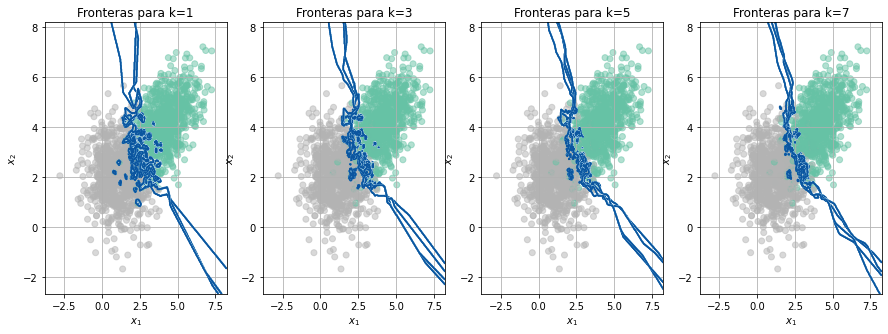

Accuracy en cada fold = [[0.905  0.91   0.8925 0.9175]
 [0.9175 0.93   0.9175 0.9375]
 [0.9275 0.9275 0.915  0.9475]
 [0.9225 0.935  0.925  0.9425]]
Accuracy promedio = [0.90625  0.925625 0.929375 0.93125 ]+/-[0.01820027 0.01709349 0.02328492 0.01600781]


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
N = 1000
Cov = np.identity(2) * 1.1
Cov2 = np.array([[1.1,0.5],[0.5,1.1]])
Mean = [1.1,2.1]
Mean2 = [4.1,4.1]
x, y  = np.random.multivariate_normal(Mean, Cov, N).T
x2, y2  = np.random.multivariate_normal(Mean2, Cov2, N).T
X = np.r_[np.c_[x,y],np.c_[x2,y2]]
Y = np.r_[np.ones((N,1)),np.zeros((N,1))]
#----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

kf = KFold(n_splits=4)
Acc = FronterasCV(X_train,y_train, kf)
print('Accuracy en cada fold = '+ np.array_str(Acc))
print('Accuracy promedio = '+str(np.mean(Acc,axis=1)) + '+/-' +str(np.std(Acc,axis=1)*2))

El mejor modelo fue para un $k=7$ 

In [26]:
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train,y_train.flatten())
y_pred = clf.predict(X_test)
print('Accuracy en test = ' + str(accuracy_score(y_test,y_pred)))

Accuracy en test = 0.96


Normalmente el error en test es un poco mayor que en validación, por eso es necesario no quedarse con el error de validación ya que puede mostrar **resultados optimistas**.

### **Leave-one-out**

Este un caso particular de la validación cruzada en la que se crean tantos folds como muestras hay en el conjunto de datos. Se usa en casos en los que el conjunto de muestras es muy pequeño y se intenta proveer al algoritmo de entrenamiento con el máximo número posible de muestras (todas menos 1) y se valida con la muestra restante. 

In [28]:
from sklearn.model_selection import LeaveOneOut

#ó

kf = KFold(n_splits=n)

### **Validación Bootstrapping (shuffle-split)**

En este la partición de las muestras entre entrenamiento y validación se realiza utilizando aleatoriamente definiendo un porcentaje para entrenamiento/validación y un número de repeticiones. La diferencia fundamental con la metodología anterior es que en el caso de Bootstrapping es posible que una misma muestra se repita en dos subconjuntos de validación. Adicionalmente en el caso de validación cruzada los porcentajes de entrenamiento y validación están definidos implícitamente por el número de folds, mientras que en Bootstrapping no.

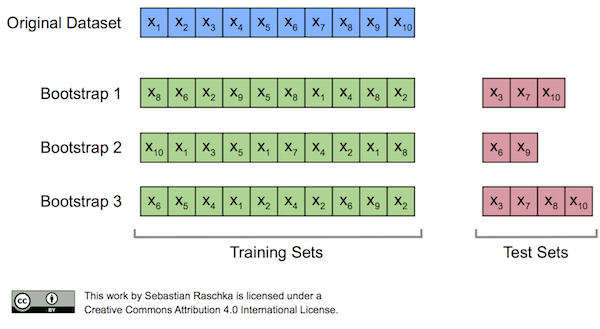

In [29]:
Image("local/imgs//bootstrap_concept.png", width = 600)

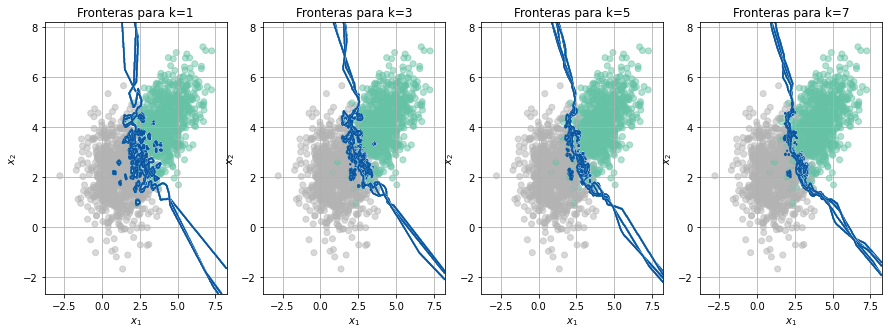

Accuracy en cada fold = [[0.9075 0.91   0.93   0.9225 0.91  ]
 [0.9175 0.9275 0.94   0.945  0.92  ]
 [0.9225 0.93   0.95   0.9525 0.935 ]
 [0.92   0.93   0.945  0.9525 0.93  ]]
Accuracy promedio = [0.916  0.93   0.938  0.9355]+/-[0.01749286 0.02167948 0.02310844 0.02332381]


In [30]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
Acc = FronterasCV(X_train,y_train, rs)
print('Accuracy en cada fold = '+ np.array_str(Acc))
print('Accuracy promedio = '+str(np.mean(Acc,axis=1)) + '+/-' +str(np.std(Acc,axis=1)*2))

Aunque en esta prueba se usó un 5% menos de muestras en el entrenamiento de cada fold, los resultados son muy similares al caso anterior, el mejor valor para el hiperparámetro $k$ es 7.

### **Leave-p-out**

Este un tipo de validación en la que no se define un porcentaje para el conjunto de validación, sino un número $p$ de muestras para validación y las restantes $n-p$ quedan para el entrenamiento. En este caso el número de repeticiones estará definido por el número de combinaciones posibles.

In [31]:
X=np.random.randn(10,2)

In [32]:
from sklearn.model_selection import LeavePOut
lpo = LeavePOut(2)
lpo.get_n_splits(X)

45

Que corresponde al número de combinaciones posibles N combinado 2.

In [33]:
from itertools import combinations 
len(list(combinations(range(X.shape[0]), 2)))

45

## **Metodología de validación para problemas desbalanceados**


Si tenemos problemas desbalanceados y usamos una metodología de validación estándar, podemos tener problemas porque la clase minoritaria queda muy mal representada en el conjunto de training.

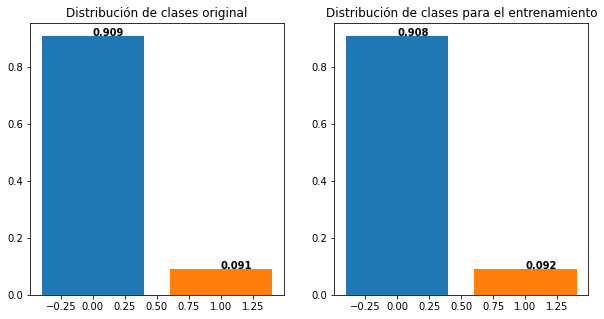

In [34]:
from sklearn.model_selection import train_test_split
N = 1000
x, y  = np.random.multivariate_normal(Mean, Cov, int(N/10)).T
x2, y2  = np.random.multivariate_normal(Mean2, Cov2, N).T
X = np.r_[np.c_[x,y],np.c_[x2,y2]]
Y = np.r_[np.ones((int(N/10),1)),np.zeros((N,1))]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(0,np.sum(Y==0)/Y.shape[0])
plt.bar(1,np.sum(Y==1)/Y.shape[0])
plt.title('Distribución de clases original')
for i in range(2):
    plt.text(i, np.sum(Y==i)/Y.shape[0], str(round(np.sum(Y==i)/Y.shape[0],3)), color='black', fontweight='bold')
#--------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=None)
plt.subplot(1,2,2)
plt.bar(0,np.sum(y_train==0)/y_train.shape[0])
plt.bar(1,np.sum(y_train==1)/y_train.shape[0])
for i in range(2):
    plt.text(i, np.sum(y_train==i)/y_train.shape[0], str(round(np.sum(y_train==i)/y_train.shape[0],3)), color='black', fontweight='bold')
plt.title('Distribución de clases para el entrenamiento')
plt.show()

Para garantizar que se mantenga la proporción del conjunto de datos original, se debe usar un versión **estratificada** de la metodología de validación:


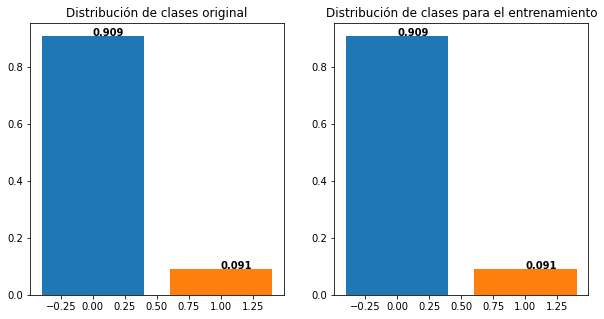

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(0,np.sum(Y==0)/Y.shape[0])
plt.bar(1,np.sum(Y==1)/Y.shape[0])
plt.title('Distribución de clases original')
for i in range(2):
    plt.text(i, np.sum(Y==i)/Y.shape[0], str(round(np.sum(Y==i)/Y.shape[0],3)), color='black', fontweight='bold')
#--------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
plt.subplot(1,2,2)
plt.bar(0,np.sum(y_train==0)/y_train.shape[0])
plt.bar(1,np.sum(y_train==1)/y_train.shape[0])
for i in range(2):
    plt.text(i, np.sum(y_train==i)/y_train.shape[0], str(round(np.sum(y_train==i)/y_train.shape[0],3)), color='black', fontweight='bold')
plt.title('Distribución de clases para el entrenamiento')
plt.show()

In [36]:
#Versión de validación cruzada estratificada
from sklearn.model_selection import StratifiedKFold

In [37]:
#Versión de validación Bootstrapping estratificada
from sklearn.model_selection import StratifiedShuffleSplit

## **Metodología de validación por grupos**


Existen problemas de ML en los que todas las muestras de entrenamiento no pueden ser consideradas independientes entre ellas, porque provienen de una fuente común. Existen dos casos:

- Las muestras de entrenamiento provienen de la misma fuente en tiempos diferentes
- El objeto sobre el cual queremos hacer predicciones están compuestos por varios vectores de características (**Multi-instance learning**)

**Ejemplo**: Si se quiere diseñar un sistemas de apoyo diagnóstico para la detección de Parkinson usando grabaciones de voz, es posible que en la base de datos que se usará para el entrenamiento del sistemas, se tengan varias grabaciones del mismo paciente tomadas en diferentes sesiones. Si no se tiene en cuenta ese factor y las muestras se tratan como independientes, puede suceder que muestras de un mismo paciente se encuentren tanto en el conjunto de entrenamiento como en el de validación, por lo que los resultados estarán sesgados de manera optimista.

Fuente de datos: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Parkinson) 

In [38]:
import pandas as pd
df = pd.read_csv("local/data/parkinsons.data",delimiter=',')
df[:10]

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
5,phon_R01_S01_6,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,...,0.06985,0.01222,21.378,1,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775
6,phon_R01_S02_1,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,...,0.02337,0.00607,24.886,1,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756
7,phon_R01_S02_2,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,...,0.02487,0.00344,26.892,1,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755
8,phon_R01_S02_3,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,...,0.03218,0.01070,21.812,1,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571
9,phon_R01_S02_4,95.056,120.103,91.226,0.00532,0.00006,0.00268,0.00332,0.00803,0.02838,...,0.04324,0.01022,21.862,1,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362


In [39]:
df.shape

(195, 24)

In [40]:
df[['name','R','Subject','Session']]= df['name'].str.split("_",expand=True)
df = df.drop(['name', 'R', 'Session'], axis=1)

In [41]:
df[:10]

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE,Subject
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,S01
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,S01
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,S01
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,S01
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,S01
5,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,0.456,...,0.01222,21.378,1,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775,S01
6,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,0.140,...,0.00607,24.886,1,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756,S02
7,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,0.134,...,0.00344,26.892,1,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755,S02
8,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,0.191,...,0.01070,21.812,1,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571,S02
9,95.056,120.103,91.226,0.00532,0.00006,0.00268,0.00332,0.00803,0.02838,0.255,...,0.01022,21.862,1,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362,S02


In [42]:
len(np.unique(df['Subject']))

32

In [43]:
Y = df['status'].values
Pacientes = df['Subject'].values
df = df.drop(['status', 'Subject'], axis=1)
X = df.values

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 0).split(df,Y, Pacientes))

**Asumiendo independencia**

In [45]:
from sklearn.preprocessing import StandardScaler

#GridSearch

scaler = StandardScaler()
Xtrain = scaler.fit_transform(X[train_inds,:]) #Para usarlo correctamente en un el GridSearch debemos definir un pipeline
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)

#--------------------------------------------------------------------------------------
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': [1,3,5,7,9], 'metric': ['minkowski'], 'p':[1,2]},
                    {'n_neighbors': [1,3,5,7,9], 'metric': ['chebyshev']}]
scores = ['precision', 'recall']
clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=rs, scoring='accuracy')
#--------------------------------------------------------------------------------------
clf.fit(Xtrain, Y[train_inds])

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['minkowski'],
                          'n_neighbors': [1, 3, 5, 7, 9], 'p': [1, 2]},
                         {'metric': ['chebyshev'],
                          'n_neighbors': [1, 3, 5, 7, 9]}],
             scoring='accuracy')

In [46]:
print(clf.best_params_)
print('Accuracy validación = '+str(clf.best_score_))

{'metric': 'minkowski', 'n_neighbors': 3, 'p': 1}
Accuracy validación = 0.9473684210526315


In [47]:
Xtest = scaler.transform(X[test_inds,:])
y_pred = clf.predict(Xtest)
print('Accuracy test = '+str(accuracy_score(Y[test_inds],y_pred)))

Accuracy test = 0.813953488372093


#### Noten la gran diferencia entre el desempeño en validación y el desempeño en test!

### Ahora probemos teniendo en cuenta los pacientes

In [48]:
rs = GroupShuffleSplit(test_size=.25, n_splits=5, random_state = 0).split(Xtrain, Y[train_inds], Pacientes[train_inds])
clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=rs, scoring='accuracy')
clf.fit(Xtrain, Y[train_inds])

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f486d8cc5d0>,
             estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['minkowski'],
                          'n_neighbors': [1, 3, 5, 7, 9], 'p': [1, 2]},
                         {'metric': ['chebyshev'],
                          'n_neighbors': [1, 3, 5, 7, 9]}],
             scoring='accuracy')

In [49]:
print(clf.best_params_)
print('Accuracy validación = '+str(clf.best_score_))

{'metric': 'minkowski', 'n_neighbors': 9, 'p': 1}
Accuracy validación = 0.8695006543843753


In [50]:
Xtest = scaler.transform(X[test_inds,:])
y_pred = clf.predict(Xtest)
print('Accuracy test = '+str(accuracy_score(Y[test_inds],y_pred)))

Accuracy test = 0.8604651162790697


**Podemos observar que**:

- La diferencia entre el error de validación y erro de test es pequeña, lo que muestra consistencia en el resultado.
- El modelo quedo mejor ajustado al problema real y el desempeño en test es 5 puntos porcentuales más alto en este caso que en el anterior.

También existe la variante validación cruzada por grupos: 

In [51]:
from sklearn.model_selection import GroupKFold

Para lo que no existe una implementación curada en sklearn es para la variante **Stratified Group Shuffle Split** o Stratified GroupKFold, pero en el [este](https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation) enlace pueden encontrar una implementación. 

-----------------

# <font color='blue'>Curva de aprendizaje</font>

Definir los porcentajes de muestras para entrenamiento y test no es una tarea sencilla y el valor apropiado dependerá del conjunto de datos con el que estemos trabajando. Una herramienta muy útil para establecer el valor adecuado de muestras de entrenamiento es construir la curva de aprendizaje.

** Ejemplo**

In [52]:
from local.lib.learning_curve import plot_learning_curve

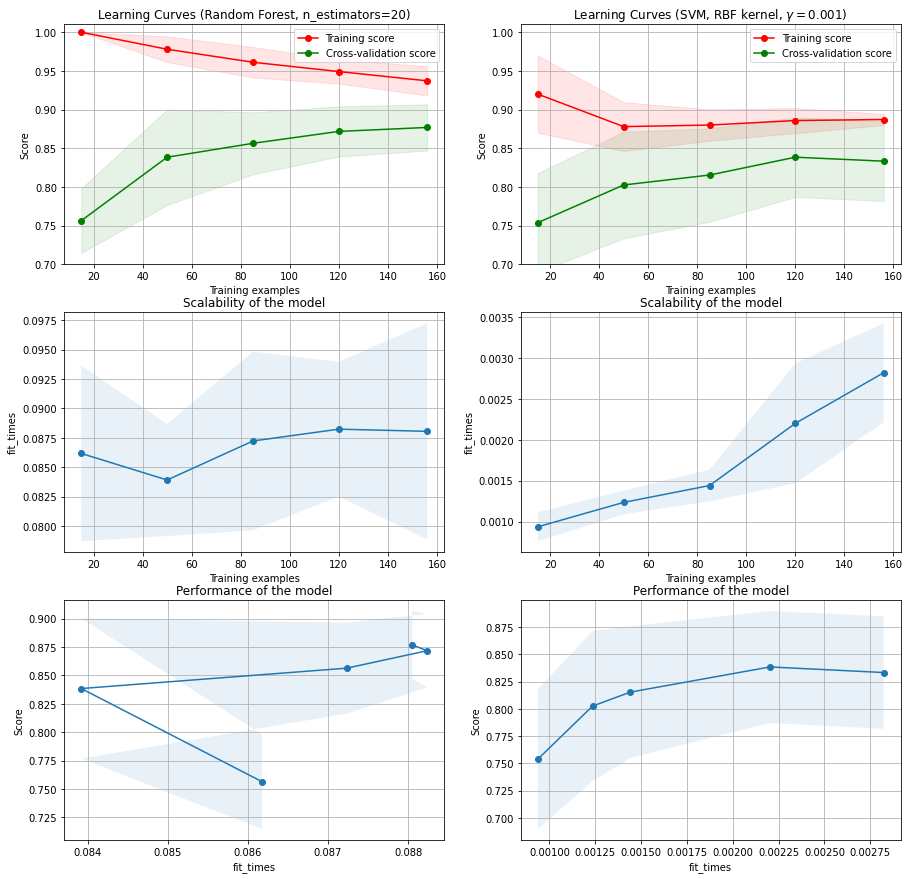

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
scaler = StandardScaler()
Xtrain = scaler.fit_transform(X)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

title = "Learning Curves (Random Forest, n_estimators=20)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

#estimator = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=1)
estimator = RandomForestClassifier(n_estimators=20 ,max_depth=3, random_state=0)
plot_learning_curve(estimator, title, Xtrain, Y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, Y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

Podemos observar que los resultados muestran comportamientos de alta varianza, es decir con cierto nivel de sobre ajuste y una clara necesidad de contar con una base de datos más grande.

El anterior análisis está hecho asumiendo que las muestras son i.i.d y usando la función:

In [54]:
from sklearn.model_selection import learning_curve

para usar **GroupKFold** o un iterador similar, que es lo recomendable en este caso, debemos realizar manualmente los diferentes experimentos para la construcción de las curvas.

### Prueba con otro conjunto de datos

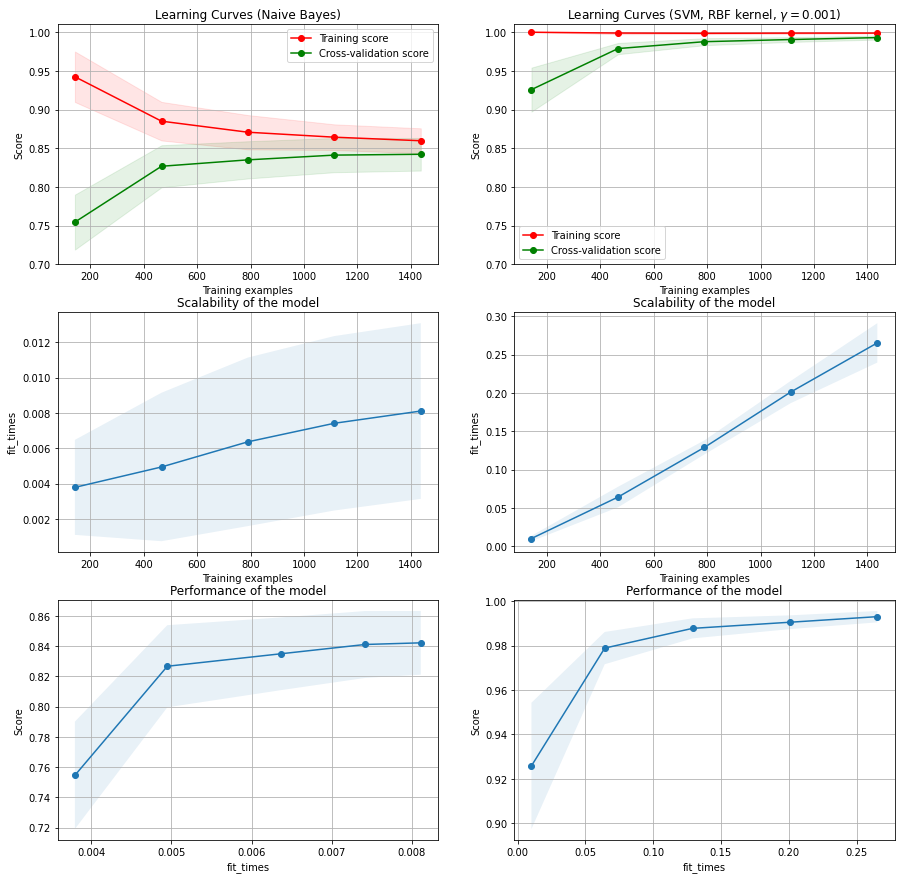

In [55]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

En este caso vemos que el modelo SVM alcanza baja varianza y bajo bias, además se requieren más de 1200 muestras para el entrenamiento del modelo.